<a href="https://colab.research.google.com/github/suresh-venkate/Code_Repositories/blob/main/Deep_Learning/Computer_Vision/Projects/Car_BBOX_Detection/Car_BBOX_Detection_Milestone_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car BBOX Detection

# Connect to Google Drive

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import required libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import pickle
import datetime
import pytz
import time
import os
import math
%matplotlib inline

from PIL import Image, ImageDraw, ImageFont
from sklearn import preprocessing

# Load Dataset and perform EDA

## Copy Dataset from Google Drive

In [3]:
%%capture

# Copy dataset from Google Drive
!cp /content/drive/MyDrive/AI_ML_Folder/Colab_Directory/Datasets/Image_Datasets/Stanford_Car_Dataset/Consolidated_Dataset.zip .
# Unzip dataset file
!unzip Consolidated_Dataset.zip
# Delete zip file
!rm Consolidated_Dataset.zip

## Define train and test image paths

In [4]:
train_img_path = '/content/train_images/'
test_img_path = '/content/test_images/'

## Create train_df and test_df

In [5]:
# Load train annotation file in a DataFrame
ann_train_red_csv_path = '/content/annot_train_red.csv'
train_df = pd.read_csv(ann_train_red_csv_path)
display(train_df.head())

,filename,xmin,ymin,xmax,ymax,label,img_h,img_w,class
0,00001.jpg,39,116,569,375,14,400.0,600.0,Audi TTS Coupe 2012
1,00017.jpg,39,52,233,150,14,194.0,259.0,Audi TTS Coupe 2012
2,00411.jpg,52,47,586,260,14,330.0,600.0,Audi TTS Coupe 2012
3,00467.jpg,47,92,209,178,14,194.0,259.0,Audi TTS Coupe 2012
4,00888.jpg,7,51,253,156,14,194.0,259.0,Audi TTS Coupe 2012


In [6]:
# Load test annotation file in a DataFrame
ann_test_red_csv_path = '/content/annot_test_red.csv'
test_df = pd.read_csv(ann_test_red_csv_path)
display(test_df.head())

,filename,xmin,ymin,xmax,ymax,label,img_h,img_w,class
0,00149.jpg,17,84,899,420,14,720.0,960.0,Audi TTS Coupe 2012
1,00155.jpg,40,110,537,292,14,355.0,569.0,Audi TTS Coupe 2012
2,00201.jpg,53,59,268,173,14,199.0,300.0,Audi TTS Coupe 2012
3,00294.jpg,67,118,959,617,14,640.0,1024.0,Audi TTS Coupe 2012
4,00688.jpg,121,184,724,487,14,600.0,800.0,Audi TTS Coupe 2012


## EDA on dataset

### Image Information

In [7]:
# Training set
print("Smallest height of images in training set is %d" %(train_df['img_h'].min()))
print("Largest height of images in training set is %d" %(train_df['img_h'].max()))
print()
print("Smallest width of images in training set is %d" %(train_df['img_w'].min()))
print("Largest width of images in training set is %d" %(train_df['img_w'].max()))
print()
print("Lowest aspect ratio of images in training set is %0.2f"\
      %((train_df['img_w']/train_df['img_h']).min()))
print("Highest aspect ratio of images in training set is %0.2f"\
      %((train_df['img_w']/train_df['img_h']).max()))

Smallest height of images in training set is 58
Largest height of images in training set is 3456

Smallest width of images in training set is 78
Largest width of images in training set is 4608

Lowest aspect ratio of images in training set is 0.67
Highest aspect ratio of images in training set is 3.20


In [8]:
# Test set
print("Smallest height of images in test set is %d" %(test_df['img_h'].min()))
print("Largest height of images in test set is %d" %(test_df['img_h'].max()))
print()
print("Smallest width of images in test set is %d" %(test_df['img_w'].min()))
print("Largest width of images in test set is %d" %(test_df['img_w'].max()))
print()
print("Lowest aspect ratio of images in test set is %0.2f"\
      %((test_df['img_w']/test_df['img_h']).min()))
print("Highest aspect ratio of images in test set is %0.2f"\
      %((test_df['img_w']/test_df['img_h']).max()))

Smallest height of images in test set is 53
Largest height of images in test set is 3240

Smallest width of images in test set is 85
Largest width of images in test set is 4320

Lowest aspect ratio of images in test set is 0.67
Highest aspect ratio of images in test set is 3.00


### Class distribution

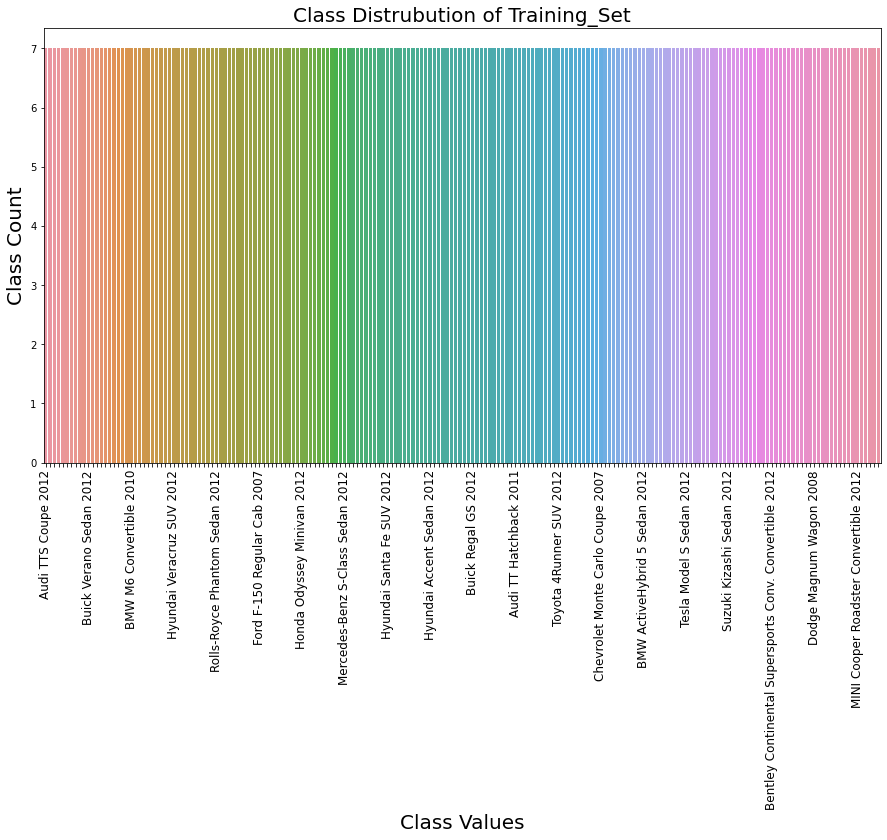

In [9]:
# Class distribution of Training set
plt.figure(figsize = (15, 8))
plot_ = sns.countplot(x = train_df['class'])
plt.title('Class Distrubution of Training_Set', fontsize = 20)
plt.xlabel('Class Values', fontsize = 20)
plt.ylabel('Class Count', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 12)
for ind, label in enumerate(plot_.get_xticklabels()):
  if (ind % 10) == 0:
    label.set_visible(True)
  else:
    label.set_visible(False)
plt.show()

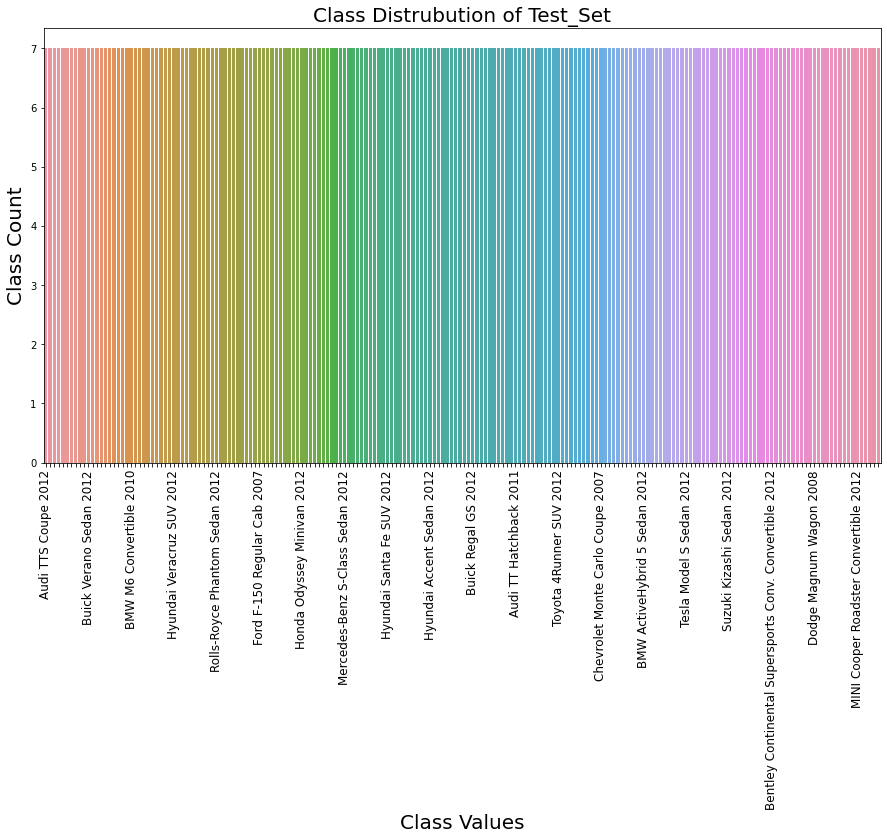

In [10]:
# Class distribution of Test set
plt.figure(figsize = (15, 8))
plot_ = sns.countplot(x = test_df['class'])
plt.title('Class Distrubution of Test_Set', fontsize = 20)
plt.xlabel('Class Values', fontsize = 20)
plt.ylabel('Class Count', fontsize = 20)
plt.xticks(rotation = 90, fontsize = 12)
for ind, label in enumerate(plot_.get_xticklabels()):
  if (ind % 10) == 0:
    label.set_visible(True)
  else:
    label.set_visible(False)
plt.show()

## Visualize images

### Define Function: viz_images

In [11]:
def viz_images(name, df, img_path, num_images, num_cols, col_size, row_size):

  '''
  Function to plot images along with labels from different sets

  Arguments:
    name: Name to print in title (Training_Set, Test_Set etc.)
    df: DataFrame from which information about image will be read
    img_path: Root path of images
    num_images: Number of images to plot
    num_cols: Number of columns to use for plotting
    col_size: Size of columns to use for plotting
    row_size: Size of rows to use for plotting

  '''

  num_rows = math.ceil(num_images / num_cols) # Number of rows to use for plotting

  fig = plt.figure(figsize = ((num_cols * col_size), (num_rows * row_size)))
  fig.suptitle('Random sample images from ' + name, fontsize = 40)

  # Generate random sample indices
  samp_index = np.random.randint(low = 0, high = df.shape[0], size = num_images).tolist()

  for ind, value in enumerate(samp_index): # Loop through samp_index
    img_file = df.loc[value, 'filename']
    img = cv2.imread(os.path.join(img_path, img_file)) # Read the image
    xmin, ymin, xmax, ymax = df.loc[value, ['xmin', 'ymin', 'xmax', 'ymax']] # Get BBOX co-ords
    obj_class = df.loc[value, 'class'] # Get Class of object
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 4) # Draw BBox in green color
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
    ax = plt.subplot(num_rows, num_cols, (ind + 1))
    ax.imshow(img)
    ax.set_title(obj_class, fontsize = 20)

  plt.show()

### Visualize images from training set

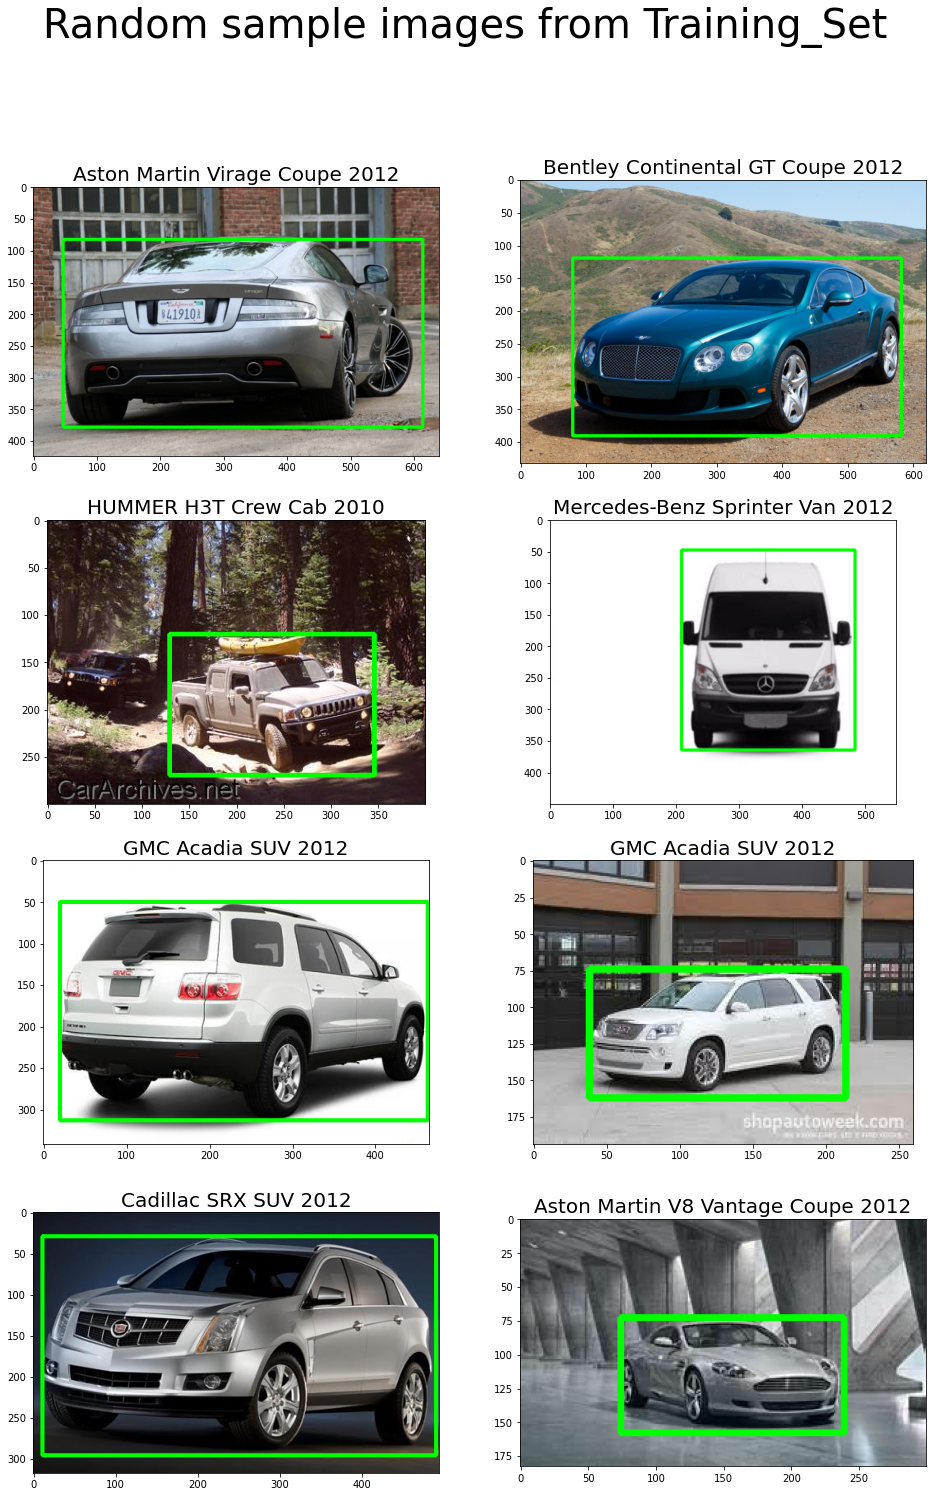

In [12]:
viz_images('Training_Set', train_df, train_img_path, 8, 2, 8, 6)

### Visualize images from test set

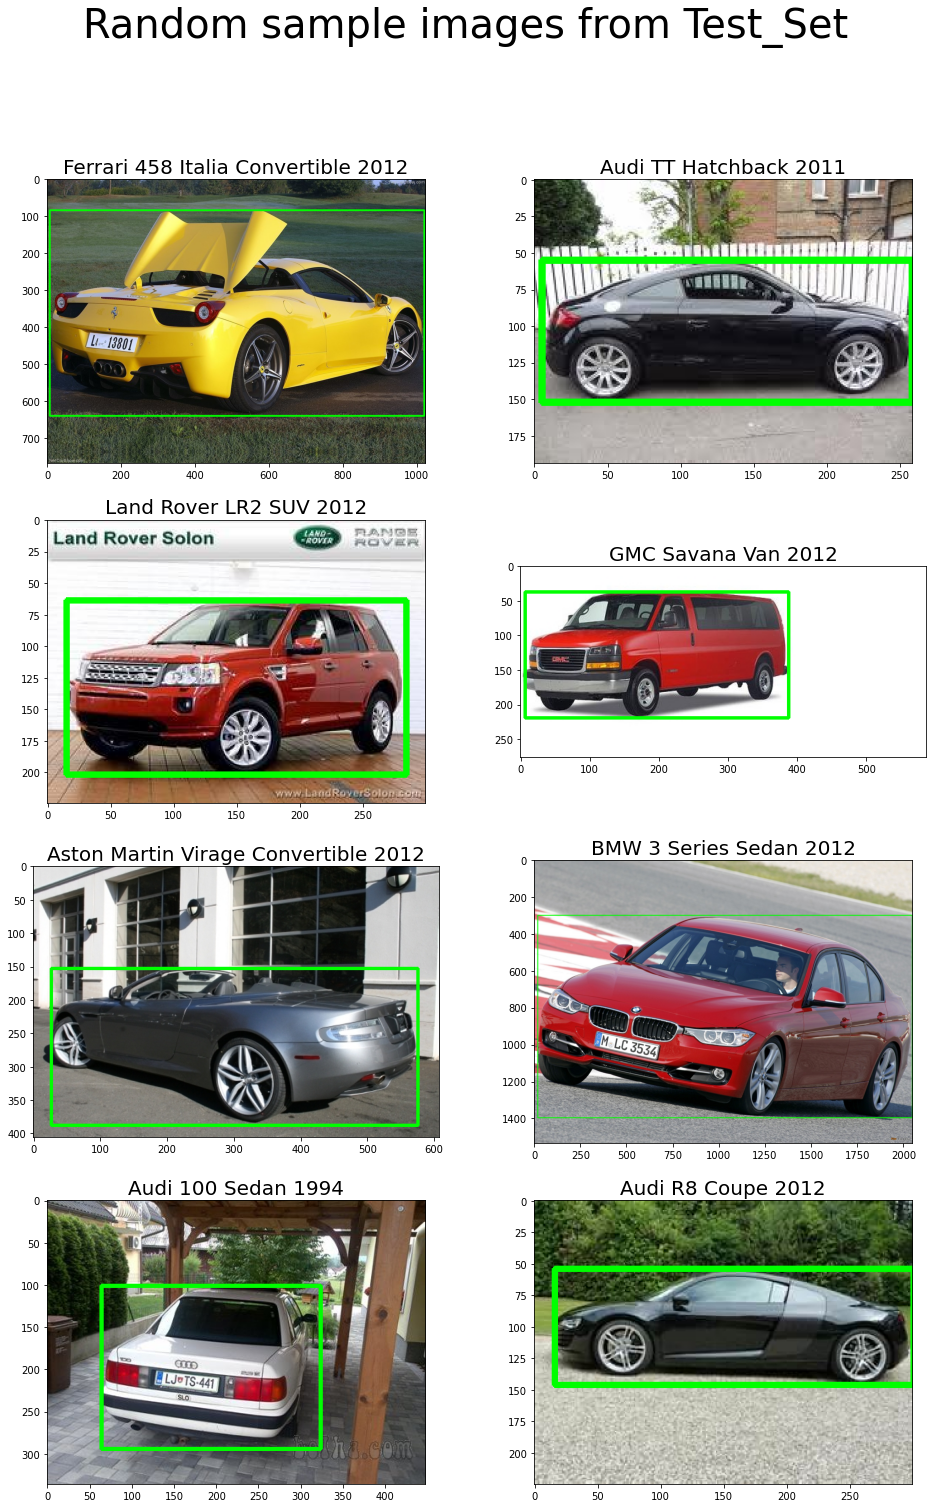

In [13]:
viz_images('Test_Set', test_df, test_img_path, 8, 2, 8, 6)